### Imports and data loading

In [24]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

## Data loading

In [25]:
google_colab = False
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "kLmDPAmiTHNw_cv3lr6wY9DfSt8RSHv"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('05-07_11-26.csv')  
    df = pd.read_csv('05-07_11-26.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    sys.path.append(path)

    # Load Model 3 prediction file
    df = pd.read_csv(path + '/data/predictions/05-07_11-26.csv')

### Data processing

In [28]:
df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'] * 365, unit='D')

In [29]:
# FIlter between 2017-12-26 and 2018-02-01
df = df[(df['Expiry_date'] <= '2015-12-31')]
df = df.sample(50000)

In [26]:
df_read = df.copy()

In [30]:
print(len(df))

148656


Adding ID

In [31]:
df["Option_ID"] = df["Expiry_date"].astype(str) + df["Strike"].astype(str)

Adding TTM=0 row

In [32]:
# Sort the dataframe by Quote_date and Expiry_date
df = df.sort_values(['Quote_date', 'Expiry_date'])

# Adding intrinsic value as Price on expirty date
# Iterate over every option, which is identified by the combination of Quote_date, Expiry_date, Strike
groups = df.groupby(['Expiry_date', 'Strike'])
for _, group in groups:
    # Create a new row for the date of expiry
    new_row = group.iloc[-1].copy()
    new_row['Price'] = max(0, new_row['Underlying_last'] - new_row['Strike'])
    new_row['TTM'] = 0
    new_row['Quote_date'] = new_row['Expiry_date']
    df = pd.concat([df, new_row.to_frame().transpose()], ignore_index=True)


# Quote_date and Expiry_date to datetime
df['Quote_date'] = pd.to_datetime(df['Quote_date'])
df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])

df_read = df.copy()


### Parameters

In [33]:
buy_threshold = 10
sell_threshold = 9
starting_balance = 1000000

### Functions

In [34]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Price']) >= buy_threshold
    sell_signal = (df['Price'] - df['Prediction']) >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance):
    df["Option_ID"] = df["Expiry_date"].astype(str) + df["Strike"].astype(str)
    last_date = df['Quote_date'].max()
    df = df[pd.to_datetime(df['Expiry_date']) < pd.to_datetime(last_date)]
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1
    df['Balance'] = starting_balance
    df["Position_this_opt"] = 0

    quote_date_grouped = df.groupby('Quote_date')

    for quote_date, group in quote_date_grouped:
        group = group.sample(frac=1)

        for _, row in group.iterrows():
            option_position = df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] <= row['Quote_date']), 'Position_this_opt'].iloc[-1]

            # Buy the option
            if row['Signal'] == 1 and option_position == 0 and row['Balance'] >= row['Price'] and row["Quote_date"] != row["Expiry_date"]:
                option_position = 1
                df.loc[(df['Quote_date'] >= row['Quote_date']) & (df['Option_ID'] == row['Option_ID']), 'Position_this_opt'] = option_position
                df.loc[df['Quote_date'] >= row['Quote_date'], 'Balance'] -= row['Price']

            # Sell the option
            if row['Signal'] == -1 and option_position == 0 and row["Quote_date"] != row["Expiry_date"]:
                option_position = -1
                df.loc[(df['Quote_date'] >= row['Quote_date']) & (df['Option_ID'] == row['Option_ID']), 'Position_this_opt'] = option_position
                df.loc[df['Quote_date'] >= row['Quote_date'], 'Balance'] += row['Price']

            # Option expires
            if row["Quote_date"] == row["Expiry_date"] and option_position != 0:
                option_position = 0
                df.loc[(df['Quote_date'] > row['Quote_date']) & (df['Option_ID'] == row['Option_ID']), 'Position_this_opt'] = option_position
                intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
                adjustment = intrinsic_value if option_position == 1 else -intrinsic_value
                df.loc[df['Quote_date'] > row['Quote_date'], 'Balance'] += adjustment
    return df



def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Run code

In [35]:
df = df_read.copy()
buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
df = trader(df, buy_signal, sell_signal, starting_balance)
df = calculate_options_value(df)

In [36]:
print("Starting balance", starting_balance)
print("Ending balance", df['Balance'].iloc[-1])
print("Number of trades", df['Signal'].abs().sum())
profit = df['Balance'].iloc[-1] - starting_balance
print("Profit", profit)
print("Profit per trade", profit / df['Signal'].abs().sum())
print("Profit per day", profit / (df['Quote_date'].max() - df['Quote_date'].min()).days)
num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days
print("Number of days", num_days)
cagr = (df['Total_value'].iloc[-1] / starting_balance) ** (365 / num_days) - 1
print("CAGR", cagr)



Starting balance 100000
Ending balance -106423.8899999997
Number of trades 11082
Profit -206423.8899999997
Profit per trade -18.626952716116197
Profit per day -2400.2777906976708
Number of days 86
CAGR nan


/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_18919/3261124750.py:10: RuntimeWarning: invalid value encountered in scalar power
  cagr = (df['Total_value'].iloc[-1] / starting_balance) ** (365 / num_days) - 1


### Analysis

In [39]:
import matplotlib.pyplot as plt

def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Balance')
    plt.plot(df['Options_value'], label='Options value')
    plt.title('Portfolio value over time')
    # Set x-axis major ticks to weekly interval, on Mondays
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

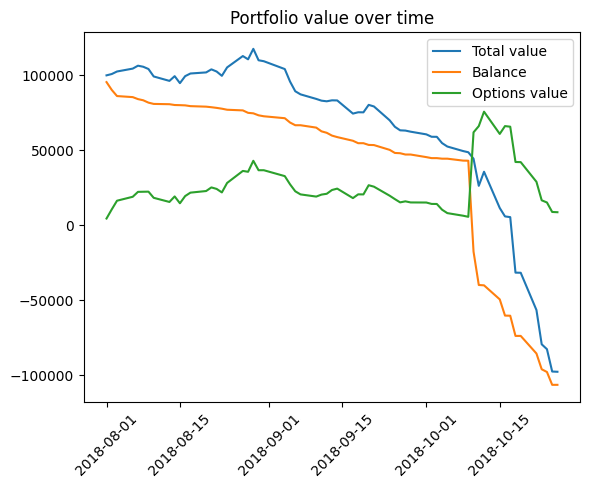

In [40]:
plot(df)

In [41]:
import numpy as np

# Calculate the sharpe ratio of the strategy using the daily returns and using df["R"] as the annualised risk-free rate
def sharpe_ratio(df):
    df["Daily_returns"] = df["Total_value"].pct_change()
    sharpe_ratio = np.sqrt(252) * ((df["Daily_returns"].mean() - (df["R"]/252).mean()) / df["Daily_returns"].std())
    return sharpe_ratio

# Calculate max drawdown
def max_drawdown(df):
    df["Drawdown"] = df["Total_value"] / df["Total_value"].cummax() - 1
    max_drawdown = df["Drawdown"].min()
    return max_drawdown

Sharpe ratio -0.11852019075607798
Max drawdown -1.8302510002376557


### Finding best thresholds

In [42]:
# Test many conbinations of sell and buy thresholds to find the one that gives the highest Sharpe ratio
def find_best_thresholds(df, starting_balance):
    best_sharpe = -100
    best_sell = 0
    best_buy = 0
    for sell in range(5, 25, 5):
        for buy in range(5, 25, 5):
            df = df_read.copy()
            buy_signal, sell_signal = generate_buy_sell_signals(df, buy, sell)
            df = trader(df, buy_signal, sell_signal, starting_balance)
            df = calculate_options_value(df)
            sharpe = sharpe_ratio(df)
            # Print and plot the results
            print("Buy threshold", buy, "Sell threshold", sell, "Sharpe ratio", sharpe)
            print("Starting balance", starting_balance, "Ending balance", df['Balance'].iloc[-1])
            print("Anualiased return", (df['Balance'].iloc[-1] / starting_balance - 1) * 252 / len(df))
            print("sharpe_ratio", sharpe_ratio(df))
            plot(df)
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_sell = sell
                best_buy = buy
    return best_sharpe, best_sell, best_buy

best_sharpe, best_sell, best_buy = find_best_thresholds(df_read, starting_balance)
print("Best Sharpe ratio", best_sharpe, "Best sell threshold", best_sell, "Best buy threshold", best_buy)